# Project - Predict the wellbeing of shanghainese communities

In [105]:
import pandas as pd
from matplotlib import pyplot
from shapely.geometry import Point, Polygon
from pandas.plotting import scatter_matrix
import numpy as np
import geopandas as gpd

In [106]:
df_target = pd.read_pickle("./dataset/TARGET-communities-extract-wellbeing.pkl")
header = df_target[0]
df_target = pd.DataFrame(data=df_target, columns=header)
df_target = df_target.drop(df_target.index[0])
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3,0.0,0.0,盈浦街道,青浦区,121.104287016932,31.1558823799679
2,万泰花园第一居委会,3,1.0,0.0,七宝镇,闵行区,121.351529089795,31.144326843509
3,万科阳光苑居委会,2,0.0,0.0,吴泾镇,闵行区,121.468520387505,31.0422853979528
4,万豪居委会,3,0.0,0.0,长征镇,普陀区,121.367237458941,31.2407251034807
5,万里名轩社区居委会,2,,0.0,万里街道,普陀区,121.403601417271,31.269155049366


cleanliness (1-4, 4 best), smell (0-1,1 worst),  noise (0-1, 1 worst)

In [107]:
len(df_target)

467

In [108]:
# Delete rows which don't have coordinates
df_target = df_target[(df_target['longitude'] != '') & (df_target['latitude'] != '')]

df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3,0.0,0.0,盈浦街道,青浦区,121.104287016932,31.1558823799679
2,万泰花园第一居委会,3,1.0,0.0,七宝镇,闵行区,121.351529089795,31.144326843509
3,万科阳光苑居委会,2,0.0,0.0,吴泾镇,闵行区,121.468520387505,31.0422853979528
4,万豪居委会,3,0.0,0.0,长征镇,普陀区,121.367237458941,31.2407251034807
5,万里名轩社区居委会,2,,0.0,万里街道,普陀区,121.403601417271,31.269155049366


In [109]:
len(df_target)

461

## Data types

### Clean, smell, noise, longitude, latitude are consider as object: convert them into number type

In [110]:
df_target['clean'] = pd.to_numeric(df_target['clean'])
df_target['smell'] = pd.to_numeric(df_target['smell'])
df_target['noise'] = pd.to_numeric(df_target['noise'])
df_target['longitude'] = pd.to_numeric(df_target['longitude'])
df_target['latitude'] = pd.to_numeric(df_target['latitude'])

In [111]:
df_target.dtypes

              object
clean          int64
smell        float64
noise        float64
town          object
district      object
longitude    float64
latitude     float64
dtype: object

In [112]:
df_target['smell'] = df_target['smell'].apply(lambda x: 1 if x==0  else 0)
df_target['noise'] = df_target['noise'].apply(lambda x: 1 if x==0  else 0)
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3,1,1,盈浦街道,青浦区,121.104287,31.155882
2,万泰花园第一居委会,3,0,1,七宝镇,闵行区,121.351529,31.144327
3,万科阳光苑居委会,2,1,1,吴泾镇,闵行区,121.468520,31.042285
4,万豪居委会,3,1,1,长征镇,普陀区,121.367237,31.240725
5,万里名轩社区居委会,2,0,1,万里街道,普陀区,121.403601,31.269155


cleanliness (1-4, 4 best), smell (0-1,0 worst),  noise (0-1, 0 worst)

In [113]:
df_target.describe()

,clean,smell,noise,longitude,latitude
count,461.000000,461.000000,461.000000,461.000000,461.000000
mean,2.557484,0.819957,0.785249,121.443524,31.213527
std,0.631986,0.384641,0.411095,0.113162,0.129333
min,1.000000,0.000000,0.000000,121.089976,30.736401
25%,2.000000,1.000000,1.000000,121.388639,31.163585
50%,3.000000,1.000000,1.000000,121.448259,31.228257
75%,3.000000,1.000000,1.000000,121.504818,31.281153
max,4.000000,1.000000,1.000000,121.892089,31.629071


## Target happiness

In [114]:
df_target['clean_coef'] = (df_target['clean']-1)/3*0.325
df_target['noise_coef'] = (df_target['noise']*0.325)
df_target['smell_coef'] = (df_target['smell']*0.35)
df_target['happiness'] = (df_target['smell_coef'] + df_target['noise_coef'] + df_target['clean_coef']) * 10
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude,clean_coef,noise_coef,smell_coef,happiness
1,万寿社区居委会,3,1,1,盈浦街道,青浦区,121.104287,31.155882,0.216667,0.325,0.35,8.916667
2,万泰花园第一居委会,3,0,1,七宝镇,闵行区,121.351529,31.144327,0.216667,0.325,0.00,5.416667
3,万科阳光苑居委会,2,1,1,吴泾镇,闵行区,121.468520,31.042285,0.108333,0.325,0.35,7.833333
4,万豪居委会,3,1,1,长征镇,普陀区,121.367237,31.240725,0.216667,0.325,0.35,8.916667
5,万里名轩社区居委会,2,0,1,万里街道,普陀区,121.403601,31.269155,0.108333,0.325,0.00,4.333333


In [115]:
geometry = [Point(xy) for xy in zip(df_target['longitude'], df_target['latitude'])]

In [116]:
df_target['geometry'] = geometry

In [117]:
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude,clean_coef,noise_coef,smell_coef,happiness,geometry
1,万寿社区居委会,3,1,1,盈浦街道,青浦区,121.104287,31.155882,0.216667,0.325,0.35,8.916667,POINT (121.104287016932 31.1558823799679)
2,万泰花园第一居委会,3,0,1,七宝镇,闵行区,121.351529,31.144327,0.216667,0.325,0.00,5.416667,POINT (121.351529089795 31.144326843509)
3,万科阳光苑居委会,2,1,1,吴泾镇,闵行区,121.468520,31.042285,0.108333,0.325,0.35,7.833333,POINT (121.468520387505 31.0422853979528)
4,万豪居委会,3,1,1,长征镇,普陀区,121.367237,31.240725,0.216667,0.325,0.35,8.916667,POINT (121.367237458941 31.2407251034807)
5,万里名轩社区居委会,2,0,1,万里街道,普陀区,121.403601,31.269155,0.108333,0.325,0.00,4.333333,POINT (121.403601417271 31.269155049366)


## Check if the point of target is in the discrict

In [118]:
df_district = pd.read_pickle("./dataset/df_district.pkl")

In [119]:
df_model = pd.DataFrame.copy(df_district[['geometry', 'surface']])

In [120]:
df_model['happiness'] = 0
df_model['nb_target'] = 0

In [121]:
sum_happiness = 0
for index, polygon in df_district['geometry'].items():
    for happy, point in zip(df_target['happiness'], df_target['geometry']):
        if point.within(polygon) == True:
            sum_happiness += happy
            df_model.loc[index, 'nb_target'] += 1
    if df_model.loc[index, 'nb_target'] > 0 : 
        df_model.loc[index, 'happiness'] = sum_happiness/df_model.loc[index, 'nb_target'] 
    else:
        df_model.loc[index, 'happiness'] = 0

In [122]:
df_model.head(7)

,geometry,surface,happiness,nb_target
0,"POLYGON Z ((121.42168 30.68471 0.00000, 121.42...",0.080387,0.000000,0
1,"POLYGON Z ((121.41199 30.69374 0.00000, 121.41...",0.374191,0.000000,0
2,"POLYGON Z ((121.40163 30.70717 0.00000, 121.40...",0.082390,0.000000,0
3,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",19.301126,0.000000,0
4,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",55.066247,0.000000,0
5,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",43.863191,8.916667,1
6,"POLYGON Z ((121.19465 30.81453 0.00000, 121.19...",46.804458,0.000000,0


In [123]:
len(df_model)

266

In [124]:
df_modelb = df_model[df_model['nb_target']>0]
df_modela = df_model[df_model['nb_target']<=0]

In [125]:
len(df_modela)+len(df_modelb)

266

In [126]:
df_model = df_modelb

In [127]:
df_model.reset_index()

,index,geometry,surface,happiness,nb_target
0,5,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",43.863191,8.916667,1
1,7,"POLYGON Z ((121.29682 30.81891 0.00000, 121.29...",34.930480,9.277778,3
2,8,"POLYGON Z ((121.36713 30.84311 0.00000, 121.36...",58.785377,22.833333,2
3,10,"POLYGON Z ((121.76851 30.88156 0.00000, 121.76...",105.243132,53.500000,1
4,11,"POLYGON Z ((121.50531 30.88954 0.00000, 121.50...",95.484156,58.083333,1
...,...,...,...,...,...
124,200,"POLYGON Z ((121.38541 31.40271 0.00000, 121.38...",40.414199,804.687500,4
125,203,"POLYGON Z ((121.21409 31.47733 0.00000, 121.21...",104.731772,1078.222222,3
126,212,"POLYGON Z ((121.70336 31.53607 0.00000, 121.70...",56.459488,1622.458333,2
127,230,"POLYGON Z ((121.63335 31.63086 0.00000, 121.63...",55.313580,1628.125000,2


### Save the model

In [128]:
df_model.to_pickle("./df_model.pickle")

### Load the model

In [98]:
df_model = pd.read_pickle("df_model.pickle")

# Features

## POI

In [82]:
df_poi = pd.read_pickle("./variables/poi_per_district.pkl")
df_poi.head()

,geometry,nb_transportation,nb_shopping,nb_restaurant,nb_scenicSpot,nb_stadiumAndGym
0,"POLYGON Z ((121.42168 30.68471 0.00000, 121.42...",0,0,0,0,0
1,"POLYGON Z ((121.41199 30.69374 0.00000, 121.41...",0,0,0,0,0
2,"POLYGON Z ((121.40163 30.70717 0.00000, 121.40...",0,0,0,0,0
3,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",1087,1789,748,28,32
4,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",1428,1762,616,9,12


In [200]:
df_features = pd.DataFrame.copy(df_poi)

## Green Space

In [84]:
df_greenspace = pd.read_pickle("./variables/greenspaces_per_district.pickle")
df_greenspace.head()

,new_geometry,green_area,green_area_proportion
35,"POLYGON ((121.44356 31.00937, 121.44338 31.009...",0.000076,0.026719
47,"POLYGON ((121.38734 31.03991, 121.38699 31.040...",0.000001,0.000759
48,"POLYGON ((121.42360 31.07339, 121.42303 31.073...",0.000004,0.001591
50,"POLYGON ((121.45789 31.10380, 121.45879 31.101...",0.000072,0.020270
53,"POLYGON ((121.46062 31.11422, 121.46045 31.113...",0.000058,0.083765


In [201]:
df_features.insert(6,'green_area_proportion', df_greenspace.green_area_proportion)

## Mobike 

In [104]:
df_mobike = pd.read_pickle("./variables/mobike_per_district.pickle")
df_mobike.head(30)

,geometry,nb_mobike,nb_mobike_proportion
0,"POLYGON Z ((121.42168 30.68471 0.00000, 121.42...",0,0.000000
1,"POLYGON Z ((121.41199 30.69374 0.00000, 121.41...",0,0.000000
2,"POLYGON Z ((121.40163 30.70717 0.00000, 121.40...",0,0.000000
3,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",0,0.000000
4,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",0,0.000000
5,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",0,0.000000
6,"POLYGON Z ((121.19465 30.81453 0.00000, 121.19...",0,0.000000
7,"POLYGON Z ((121.29682 30.81891 0.00000, 121.29...",0,0.000000
8,"POLYGON Z ((121.36713 30.84311 0.00000, 121.36...",2,360.981556
9,"POLYGON Z ((121.17453 30.87610 0.00000, 121.17...",0,0.000000


In [ ]:
df_features.insert(7,'nb_mobike', df_mobike.nb_mobike)

# Clean features

In [202]:
# Drop row where all the features are null
columns = ['nb_transportation', 'nb_shopping', 'nb_restaurant', 'nb_scenicSpot', 'nb_stadiumAndGym', 'green_area_proportion']
df_features = df_features.replace(0, pd.np.nan).dropna(axis=0, how='all', subset=columns)

In [203]:
df_features[columns] = df_features[columns].fillna(0).astype(float)

In [204]:
df_features.reset_index()

,index,geometry,nb_transportation,nb_shopping,nb_restaurant,nb_scenicSpot,nb_stadiumAndGym,green_area_proportion
0,3,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",1087.0,1789.0,748.0,28.0,32.0,0.0
1,4,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",1428.0,1762.0,616.0,9.0,12.0,0.0
2,5,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",1622.0,2152.0,1131.0,14.0,28.0,0.0
3,6,"POLYGON Z ((121.19465 30.81453 0.00000, 121.19...",492.0,197.0,86.0,9.0,4.0,0.0
4,7,"POLYGON Z ((121.29682 30.81891 0.00000, 121.29...",835.0,374.0,177.0,12.0,7.0,0.0
...,...,...,...,...,...,...,...,...
243,261,"POLYGON Z ((121.18624 31.80997 0.00000, 121.18...",302.0,18.0,15.0,4.0,0.0,0.0
244,262,"POLYGON Z ((121.40581 31.79716 0.00000, 121.40...",7.0,0.0,0.0,0.0,0.0,0.0
245,263,"POLYGON Z ((121.24444 31.84448 0.00000, 121.24...",230.0,28.0,17.0,1.0,0.0,0.0
246,264,"POLYGON Z ((121.26771 31.84871 0.00000, 121.26...",1.0,0.0,0.0,0.0,0.0,0.0


# Modeling

In [219]:
df_model = pd.merge(df_model, df_features, left_on='geometry', right_on='geometry')

In [220]:
df_model.head()

,geometry,happiness,nb_transportation,nb_shopping,nb_restaurant,nb_scenicSpot,nb_stadiumAndGym,green_area_proportion
0,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",0.000000,1087.0,1789.0,748.0,28.0,32.0,0.0
1,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",0.000000,1428.0,1762.0,616.0,9.0,12.0,0.0
2,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",8.916667,1622.0,2152.0,1131.0,14.0,28.0,0.0
3,"POLYGON Z ((121.19465 30.81453 0.00000, 121.19...",0.000000,492.0,197.0,86.0,9.0,4.0,0.0
4,"POLYGON Z ((121.29682 30.81891 0.00000, 121.29...",9.277778,835.0,374.0,177.0,12.0,7.0,0.0


In [221]:
df_model.shape

(248, 8)

248 observations and 6 features

### Save model pickle

In [222]:
df_model.to_pickle("./df_model.pickle")

### Load model pickle

In [209]:
df_model = pd.read_pickle("df_model.pickle")

## Scale features

In [223]:
df_model.columns

Index(['geometry', 'happiness', 'nb_transportation', 'nb_shopping',
       'nb_restaurant', 'nb_scenicSpot', 'nb_stadiumAndGym',
       'green_area_proportion'],
      dtype='object')

In [224]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #scaler like 'centré réduit'
# Fit: select some columns, it's expecting more than one column so u need to write like this [[]]
df_model['nb_transportation_scaled'] = scaler.fit_transform(df_model[['nb_transportation']])
df_model['nb_shopping_scaled'] = scaler.fit_transform(df_model[['nb_shopping']])
df_model['nb_restaurant_scaled'] = scaler.fit_transform(df_model[['nb_restaurant']])
df_model['nb_scenicSpot_scaled'] = scaler.fit_transform(df_model[['nb_scenicSpot']])
df_model['nb_stadiumAndGym_scaled'] = scaler.fit_transform(df_model[['nb_stadiumAndGym']])
df_model['green_area_proportion_scaled'] = scaler.fit_transform(df_model[['green_area_proportion']])

In [225]:
print(scaler.mean_)

[0.02211763]


In [226]:
df_model.head()

,geometry,happiness,nb_transportation,nb_shopping,nb_restaurant,nb_scenicSpot,nb_stadiumAndGym,green_area_proportion,nb_transportation_scaled,nb_shopping_scaled,nb_restaurant_scaled,nb_scenicSpot_scaled,nb_stadiumAndGym_scaled,green_area_proportion_scaled
0,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",0.000000,1087.0,1789.0,748.0,28.0,32.0,0.0,0.142085,0.213356,-0.195755,0.142784,0.016965,-0.50485
1,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",0.000000,1428.0,1762.0,616.0,9.0,12.0,0.0,0.586952,0.195711,-0.347412,-0.395885,-0.592775,-0.50485
2,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",8.916667,1622.0,2152.0,1131.0,14.0,28.0,0.0,0.840043,0.450578,0.244278,-0.254130,-0.104983,-0.50485
3,"POLYGON Z ((121.19465 30.81453 0.00000, 121.19...",0.000000,492.0,197.0,86.0,9.0,4.0,0.0,-0.634149,-0.827023,-0.956335,-0.395885,-0.836670,-0.50485
4,"POLYGON Z ((121.29682 30.81891 0.00000, 121.29...",9.277778,835.0,374.0,177.0,12.0,7.0,0.0,-0.186673,-0.711353,-0.851784,-0.310832,-0.745209,-0.50485


## Split data into training and test sets

In [227]:
df_predict = df_model[['nb_transportation_scaled', 'nb_shopping_scaled', 'nb_restaurant_scaled', 'nb_scenicSpot_scaled', 'nb_stadiumAndGym_scaled', 'green_area_proportion_scaled', 'happiness']]

In [228]:
df_predict.to_pickle("df_predict.pkl")

In [229]:
X = df_predict[['nb_transportation_scaled', 'nb_shopping_scaled', 'nb_restaurant_scaled', 'nb_scenicSpot_scaled', 'nb_stadiumAndGym_scaled', 'green_area_proportion_scaled']] #features
Y = df_predict['happiness'] #target

## Classification

In [231]:
Z = pd.DataFrame.copy(Y)
Z[Y <= np.median(Y)] = "Unhappy"
Z[Y > np.median(Y)] = "Happy"

In [235]:
df_predict['class'] = Z

C:\Users\Aurelie\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [237]:
df_predict.groupby('class').size()

class
Happy      124
Unhappy    124
dtype: int64

## Explore the data

### Hist

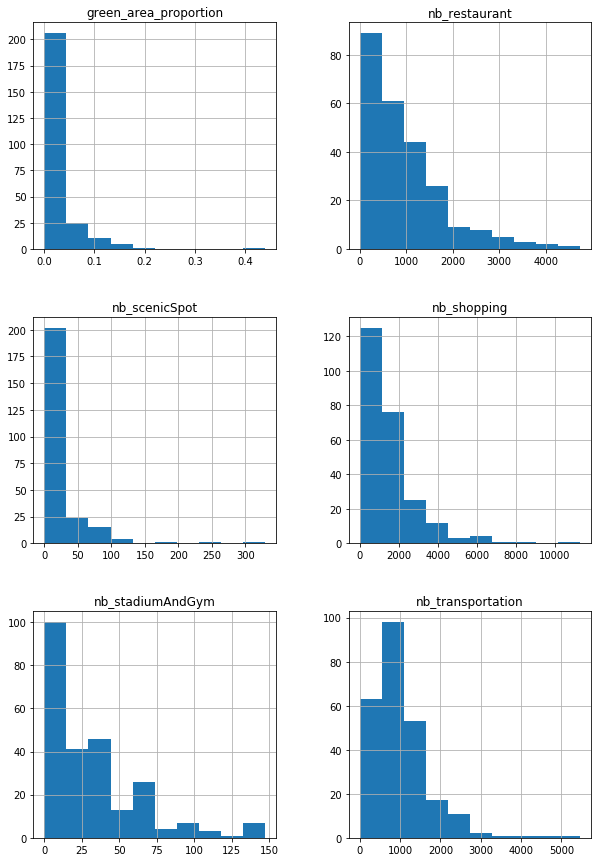

In [238]:
features.hist(figsize=(10,15))
pyplot.show()

## Scatter Matrix Plot for each input variables: show how much one variable is affected by another

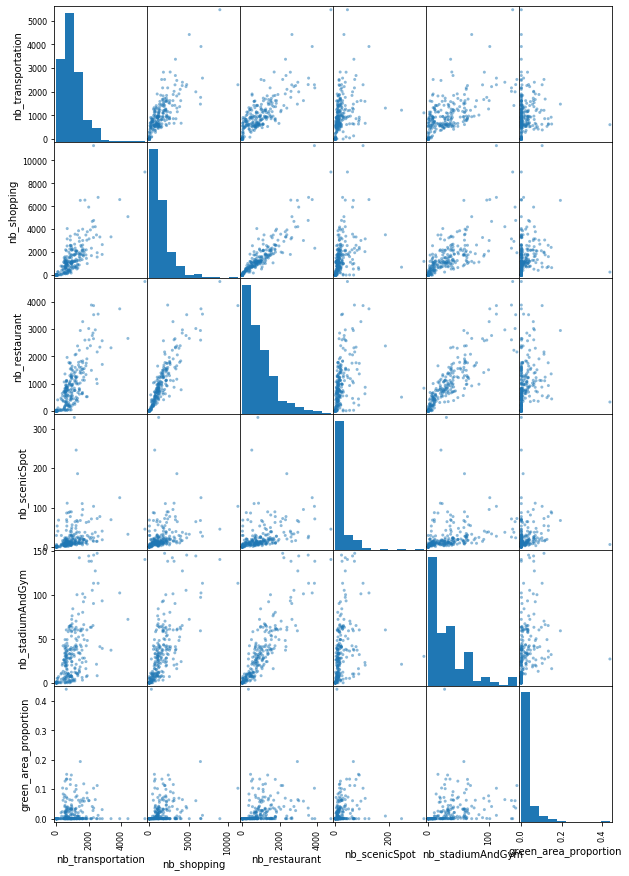

In [239]:
# scatter plot matrix
scatter_matrix(features, figsize=(10,15))
pyplot.show()

## Split data into training and test sets

In [240]:
from sklearn.model_selection import train_test_split
X_train, X_test, Z_train, Z_test = train_test_split(X, Z, test_size=0.3, random_state=123, stratify=Z)

## Grid Search: find the best parameters for the model

In [42]:
from sklearn.model_selection import GridSearchCV

## 1. K-Nearest Neighbors - KNN

In [ ]:
from sklearn import neighbors, datasets
n_neighbors = 2000
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
scores = cross_val_score(clf, X, Z, cv=5)
clf.fit(X, Z)
np.mean(scores)

## 2. Support Vector Machines - SVM

## Evaluate each model

In [253]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [246]:
models = []

In [247]:
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(gamma='auto')))

In [249]:
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Z_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

KNN: 0.623325 (0.105357)
SVM: 0.652165 (0.079746)


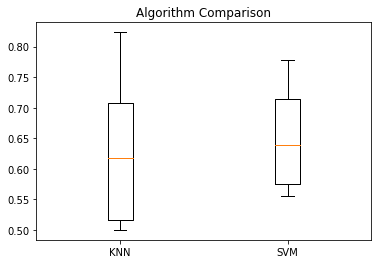

In [250]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

# Best model

In [254]:
model = SVC(gamma='auto')
model.fit(X_train, Z_train)
predictions = model.predict(X_test)

In [258]:
print('Accuracy score: ', accuracy_score(Z_test, predictions))
print('Confusion Matrix: ')
print(confusion_matrix(Z_test, predictions))
print('Classification report: ')
print(classification_report(Z_test, predictions))

Accuracy score:  0.76
Confusion Matrix: 
[[31  7]
 [11 26]]
Classification report: 
              precision    recall  f1-score   support

       Happy       0.74      0.82      0.78        38
     Unhappy       0.79      0.70      0.74        37

    accuracy                           0.76        75
   macro avg       0.76      0.76      0.76        75
weighted avg       0.76      0.76      0.76        75

